In [1]:
using Plots
using LinearAlgebra
using Statistics
using Distributions
using JuMP
using COSMO
using DataFrames

In [2]:
# Simulate data to get a covariance matrix

function mean_Cov()

    normal_slotA = Normal(10.0, .7)
    normal_slotB = Normal(15.0, 1)
    normal_slotC = Normal(5.0, 0.3)
    normal_blackJack = Normal(12.0, 1)
    normal_craps = Normal(12.6, 0.8)
    data = [rand(normal_slotA, 1000) rand(normal_slotB, 1000) rand(normal_slotC, 1000) rand(normal_blackJack, 1000) rand(normal_craps, 1000)]
    
    return mean(data,dims=1)',cov(data)
end

μ, Σ = mean_Cov();

In [3]:
Σ

5×5 Array{Float64,2}:
  0.485841    -0.0231956   -0.0127645   -0.00365172   0.068132
 -0.0231956    1.01813      0.00519239  -0.00713005  -0.0145441
 -0.0127645    0.00519239   0.0954775    0.00342723  -0.00694693
 -0.00365172  -0.00713005   0.00342723   1.06698     -0.01369
  0.068132    -0.0145441   -0.00694693  -0.01369      0.682999

In [4]:
μ

5×1 Adjoint{Float64,Array{Float64,2}}:
 10.006371735700963
 14.967790428261782
  5.0024931175575595
 12.000001206547386
 12.571311799367212

In [5]:
names = ["Slot A","Slot B","Slot C","Black Jack","Craps"] # for DataFrames


# Form feasible casinos using a brute force approach
function randomCasino()
    s = [1;1;1;6;9]
    b = [0;0;0;1;0]
    c = [0;0;0;0;1]
    d = [0;0;0;1;3]
    g = rand(1:250, 5)
    while( g's != 256 || g'b <= 5 || g'd >= 35 || g'c <= 3)
        g = rand(1:250, 5)
    end
    return g
end  

randomCasino (generic function with 1 method)

In [36]:
s = [1;1;1;6;9]
b = [0;0;0;1;0]
c = [0;0;0;0;1]
d = [0;0;0;1;3]

g = randomCasino()
DataFrame(Games = names, Amounts = g)

,Games,Amounts
,String,Int64
1,Slot A,25
2,Slot B,13
3,Slot C,68
4,Black Jack,19
5,Craps,4


In [43]:
g'd

31

In [30]:
# the plot that I will keep appending to 
plt = plot( title = "Casinos", xlabel = "Standard Deviation", ylabel = "House Edege",  bg = RGB(0.2, 0.2, 0.2),legend=:topleft);

In [9]:
# Begin showing the efficient frontier by plotting random casinos

n = 100

σ_rand = zeros(n)
μ_rand = zeros(n)

for i in 1:n
    g = randomCasino()
    σ_rand[i] = sqrt(g'*Σ*g)
    μ_rand[i] = dot(μ,g)
end

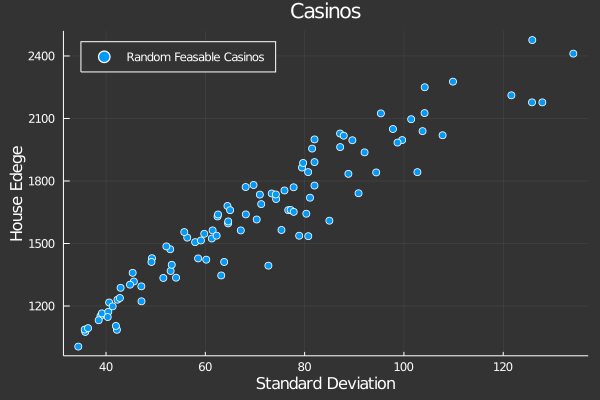

In [31]:
# A scatter plot of 100 random casinos
scatter!(σ_rand,μ_rand, label = "Random Feasable Casinos")

In [11]:
# the JuMP model

function build_model(Σ, μ, r, seatLimit, blackJackMin, crapsMin, dealerMax, optimizer, eps_abs, eps_rel)

    model = Model()
    set_silent(model)
    
    s = [1;1;1;6;9]
    b = [0;0;0;1;0]
    c = [0;0;0;0;1]
    d = [0;0;0;1;3]

    @variable(model, g[1:size(Σ,1)] >= 0)
    
    @constraint(model, blackjackTables,  blackJackMin - dot(g,b) <= 0)
    @constraint(model, crapsTables, crapsMin - dot(g,c) <= 0)
    @constraint(model, dealers, dot(g,d) - dealerMax <= 0 )
    @constraint(model, seats, dot(g,s) - seatLimit == 0)
    
    @constraint(model, efficentReturn, r - dot(g,μ) <= 0)
    
    @objective(model, Min, g'*Σ*g)

    set_optimizer(model, optimizer.Optimizer)
    set_optimizer_attribute(model, "eps_abs", eps_abs)
    set_optimizer_attribute(model, "eps_rel", eps_rel)
    optimize!(model,)
    
    return value.(g), model
end

build_model (generic function with 1 method)

In [12]:
r=0
seatLimit = 256.0
blackJackMin = 5.0
crapsMin = 3.0 
dealerMax = 35.0

optimizer = COSMO
eps_abs = 0.0000005
eps_rel = 0.0000005


g,  model = build_model(Σ, μ, r, seatLimit, blackJackMin, crapsMin, dealerMax, optimizer, eps_abs, eps_rel)
model

A JuMP Model
Minimization problem with:
Variables: 5
Objective function type: GenericQuadExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 5 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: COSMO
Names registered in the model: blackjackTables, crapsTables, dealers, efficentReturn, g, seats

In [13]:
# look at the min var
DataFrame(Games = names, Amounts = g)

,Games,Amounts
,String,Float64
1,Slot A,15.1559
2,Slot B,6.6685
3,Slot C,70.3402
4,Black Jack,19.6118
5,Craps,5.1294


In [28]:
# look at a close interger minvar
close_integer_min = [15,6,70,20,5]
DataFrame(Games = names, Amounts = close_integer_min)

,Games,Amounts
,String,Int64
1,Slot A,15
2,Slot B,6
3,Slot C,70
4,Black Jack,20
5,Craps,5


In [29]:
# compare
norm(close_integer_min'*Σ*close_integer_min - g'*Σ*g)/norm(g'*Σ*g)

0.0006267589602025833

In [16]:
#trace the frontier
enume = enumerate(dot(g,μ):0.1:dot(g,μ)+2000)
μ_frontier = zeros(size(enume))
σ_frontier = zeros(size(enume))
for r in enume
    temp_g, _ = build_model(Σ, μ, r[2], seatLimit, blackJackMin, crapsMin, dealerMax, optimizer, eps_abs, eps_rel)
    μ_frontier[r[1]] = dot(temp_g,μ)
    σ_frontier[r[1]] = sqrt(temp_g'Σ*temp_g)
end

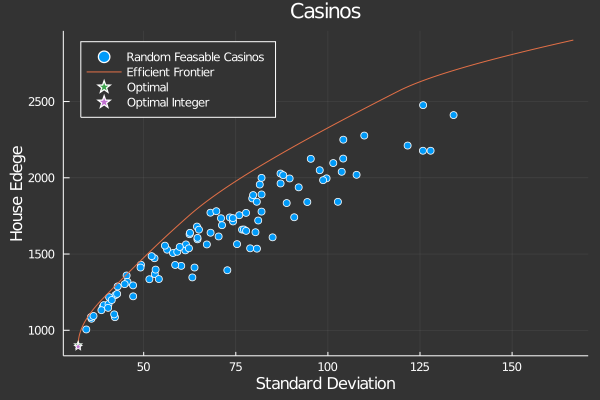

In [32]:
plot!(σ_frontier,μ_frontier, label = "Efficient Frontier")
scatter!([sqrt(g'*Σ*g)], [μ'*g], m=:star, label = "Optimal")
scatter!([sqrt(close_integer_min'*Σ*close_integer_min)], [μ'*close_integer_min], m=:star, label = "Optimal Integer")

In [34]:
# Fill in set with convex combinations
n = 25
k = 100

conv_σ_rand = zeros(k)
conv_μ_rand = zeros(k)

gs = [randomCasino() for j in 1:k]

for i in 1:k

    theta = rand(k,1)
    theta = theta./sum(theta)
    conv_g = sum(gs .* theta)
    conv_σ_rand[i] = sqrt(conv_g'*Σ*conv_g)
    conv_μ_rand[i] = dot(conv_g,μ)
    if(i%n == 0)
        gs = [randomCasino() for j in 1:k]
    end
    
end

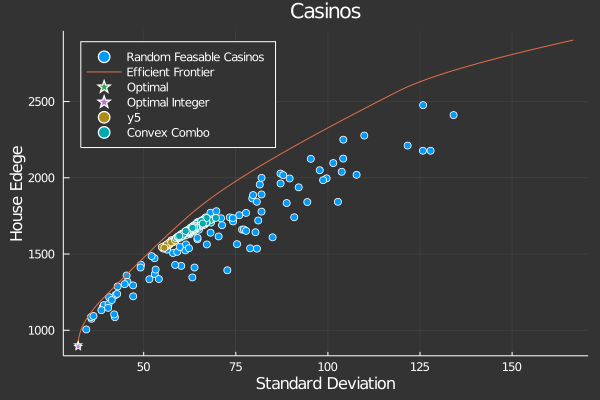

In [35]:
scatter!(conv_σ_rand, conv_μ_rand, label = "Convex Combo")